In [61]:
import numpy as np
import pandas as pd

from sklearn import svm
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from scipy.sparse import hstack
from sklearn import svm
import time
import numpy as np
#from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn
%matplotlib inline

In [ ]:
#import keras
#from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
#from keras.callbacks import Callback
#from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
#from keras.preprocessing import text, sequence
#from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
#from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
#from keras.callbacks import EarlyStopping,ModelCheckpoint
#from keras.models import Model
#from keras.optimizers import Adam
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import roc_auc_score

In [31]:
train_pos_path = 'C:\\Users\\hudie\\OneDrive\\Documents\\NBA\\aclImdb_v1\\aclImdb\\train\\pos'
train_neg_path = 'C:\\Users\\hudie\\OneDrive\\Documents\\NBA\\aclImdb_v1\\aclImdb\\train\\neg'
test_pos_path = 'C:\\Users\\hudie\\OneDrive\\Documents\\NBA\\aclImdb_v1\\aclImdb\\test\\pos'
test_neg_path = 'C:\\Users\\hudie\\OneDrive\\Documents\\NBA\\aclImdb_v1\\aclImdb\\test\\neg'


In [3]:
train_pos_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(train_pos_path + "\*.txt")]
train_neg_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(train_neg_path + "\*.txt")]

In [32]:
test_pos_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(test_pos_path + "\*.txt")]
test_neg_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(test_neg_path + "\*.txt")]

In [33]:
train_pos_df = pd.DataFrame(train_pos_reviews,columns =['review']) 
train_pos_df['sentiment'] = 1
train_neg_df = pd.DataFrame(train_neg_reviews,columns =['review']) 
train_neg_df['sentiment'] = 0
train_df = pd.concat([train_pos_df,train_neg_df], axis = 0)

test_pos_df = pd.DataFrame(test_pos_reviews,columns =['review']) 
test_pos_df['sentiment'] = 1
test_neg_df = pd.DataFrame(test_neg_reviews,columns =['review']) 
test_neg_df['sentiment'] = 0
test_df = pd.concat([test_pos_df,test_neg_df], axis = 0)


In [9]:
train_df.head(3)

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1


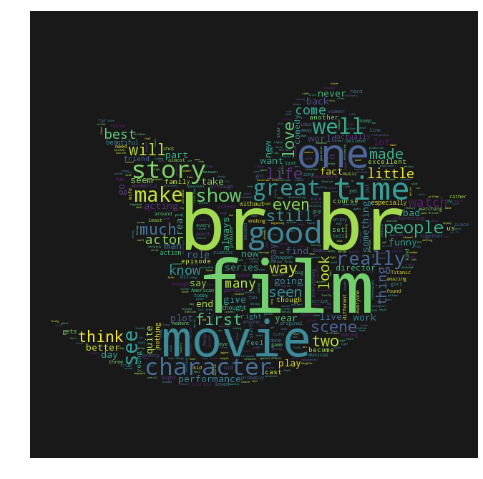

In [29]:
stopword=set(STOPWORDS)
clean_mask=np.array(Image.open("C:\\Users\\hudie\\oneDrive\\Documents\\mask.jpg"))
clean_mask=clean_mask[:,:,1]
x='sentiment'
subset=train_df[train_df[x]==1][:1000]
text=subset.review.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=0), alpha=0.9)
plt.show()

In [39]:
train_text = train_df["review"]
test_text = test_df["review"]
all_text = pd.concat([train_text, test_text])
all_text.head(3)

0    Bromwell High is a cartoon comedy. It ran at t...
1    Homelessness (or Houselessness as George Carli...
2    Brilliant over-acting by Lesley Ann Warren. Be...
Name: review, dtype: object

In [40]:
# vectorize text, remove stopwords, apply tfidf and ngram
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=False, # uper case could beuseful to reflect stronger emotion
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),  # 1,2,3 gram
    max_features=100)  # to save time i'm using 100, here we change to 10000 could boost performance in trade of time
#feature extraction using train and test text
word_vectorizer.fit(all_text)
print("word_vectoriezed....finished")
# text to tf-idf vector
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

word_vectoriezed....finished


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1015: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [63]:
# here we do a character feature vectrorization, this is to capture additional text info written in abbreviation or single char
scores = []
start_time = time.time()

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    
    stop_words='english',
    ngram_range=(2, 3),
    max_features=100)  #change to 10000 in final ver



char_vectorizer.fit(all_text)
print("char vectorizing....")
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)



train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)

char vectorizing....


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1015: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


elapsed_time is: 209.66572189331055


In [69]:
## use word N-gram Features
scores = []
start_time = time.time()

for class_name in ['sentiment']:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1)

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    #print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
print("here we use both word N-gram features")
print('Total cross-validation accuracy is {},using Logistic Regression'.format(np.mean(scores)))


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)

here we use both word N-gram features
Total cross-validation accuracy is 0.7126802107391658,using Logistic Regression
elapsed_time is: 0.37203288078308105


In [70]:
## use word N-gram Features # here we compare stochatic average gradient solver vs libliner's sgd
# typical 
scores = []
start_time = time.time()
for class_name in ['sentiment']:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    #print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
print("here we use both word N-gram features")
print('Total cross-validated accuracy is {},using Logistic Regression'.format(np.mean(scores)))


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)

here we use both word N-gram features
Total cross-validated accuracy is 0.7126001979371175,using Logistic Regression
elapsed_time is: 0.4188826084136963


In [84]:
## use both word and character N-gram features
scores = []
start_time = time.time()
#submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in ['sentiment']:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1, solver='liblinear')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    #print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
print("here we use both word and character N-gram features")
print('Total cross-validation acc score is {},using Logistic Regression'.format(np.mean(scores)))


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)
# here no much boost in adding char feature

here we use both word and character N-gram features
Total cross-validation acc score is 0.7258805757373303,using Logistic Regression
elapsed_time is: 1.8261523246765137


for lamda is:  0.001
Total cross-validation accuracy is 0.7007996825448396,using Logistic Regression
elapsed_time is: 1.4521188735961914
for lamda is:  0.1
Total cross-validation accuracy is 0.725600521329393,using Logistic Regression
elapsed_time is: 2.8224527835845947
for lamda is:  0.5
Total cross-validation accuracy is 0.7330804414187432,using Logistic Regression
elapsed_time is: 8.040532350540161


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  1
Total cross-validation accuracy is 0.736480515068156,using Logistic Regression
elapsed_time is: 9.759897232055664


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  2
Total cross-validation accuracy is 0.7388404990970862,using Logistic Regression
elapsed_time is: 9.370916604995728


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  5
Total cross-validation accuracy is 0.7418804959357453,using Logistic Regression
elapsed_time is: 9.420806884765625


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  10
Total cross-validation accuracy is 0.7425604415400969,using Logistic Regression
elapsed_time is: 9.170480728149414


C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hudie\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  100
Total cross-validation accuracy is 0.7426004287395847,using Logistic Regression
elapsed_time is: 10.751250267028809


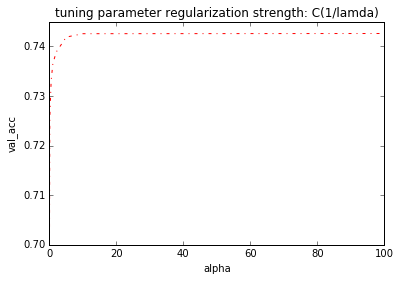

In [85]:
#tune for regularization
param_l=[]
error_l=[]
for lamda in [0.001,0.1,0.5,1,2,5,10,100]:
    scores = []
    start_time = time.time()

    for class_name in ['sentiment']:
        train_target = train_df[class_name]
        classifier = LogisticRegression(C=lamda,penalty="l2", solver='sag')

        cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
        scores.append(cv_score)
            #print('CV score for class {} is {}'.format(class_name, cv_score))

        classifier.fit(train_features, train_target)

    print("for lamda is: ", lamda )
    print('Total cross-validation accuracy is {},using Logistic Regression'.format(np.mean(scores)))
    param_l.append(lamda)
    error_l.append(np.mean(scores))

    elapsed_time = time.time() - start_time
    print("elapsed_time is:",elapsed_time)

plt.title("tuning parameter regularization strength: C(1/lamda)")
plt.ylabel("val_acc")
plt.xlabel("alpha")
plt.plot(param_l, error_l, color="red", linewidth=1.0, linestyle="-.")

Try SVM using a linear kernal....Total CV accuracy is 0.6967594680759673
elapsed_time is: 0.9215338230133057
Try SVM using a linear kernal....Total CV accuracy is 0.7030796921747942
elapsed_time is: 1.8670072555541992
Try SVM using a linear kernal....Total CV accuracy is 0.714226641673435
elapsed_time is: 3.1037018299102783
Try SVM using a linear kernal....Total CV accuracy is 0.721580106044709
elapsed_time is: 6.672157049179077
Try SVM using a linear kernal....Total CV accuracy is 0.7258321859455277
elapsed_time is: 12.975306272506714
Try SVM using a linear kernal....Total CV accuracy is 0.7285269170785109
elapsed_time is: 46.47942304611206


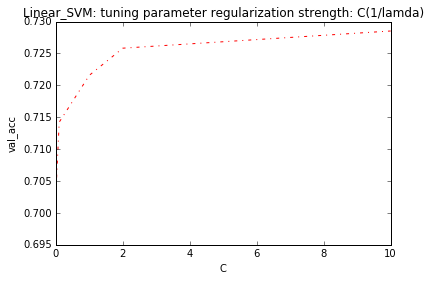

In [86]:
scores = []
start_time = time.time()
param_l=[]
error_l=[]
for param in [0.0001,0.001,0.1,1,2,10]:
    #submission = pd.DataFrame.from_dict({'id': test['id']})
    for class_name in ['sentiment']:
        train_target = train_df[class_name]
        classifier = LinearSVC(C=param)

        cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
        scores.append(cv_score)
        #print('CV score for class {} is {}'.format(class_name, cv_score))


        #param_range = np.logspace(-6, -1, 5)
        #train_scores, test_scores = validation_curve(
        #SVC(), train_features, train_target, param_name="gamma", param_range=param_range,
        #cv=10, scoring="roc_auc")


        classifier.fit(train_features, train_target)
        #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
    param_l.append(param)
    error_l.append(np.mean(scores))
    print('Try SVM using a linear kernal....Total CV accuracy is {}'.format(np.mean(scores)))
    elapsed_time = time.time() - start_time
    print("elapsed_time is:",elapsed_time)


plt.title("Linear_SVM: tuning parameter regularization strength: C(1/lamda)")
plt.ylabel("val_acc")
plt.xlabel("C")
plt.plot(param_l, error_l, color="red", linewidth=1.0, linestyle="-.")



for prior_class 0.1
Using naive bayes...Total CV acc score is 0.5
elapsed_time is: 0.0817866325378418
-------------------------
for prior_class 0.2
Using naive bayes...Total CV acc score is 0.5000800032012801
elapsed_time is: 0.06981134414672852
-------------------------
for prior_class 0.3
Using naive bayes...Total CV acc score is 0.5085200193106011
elapsed_time is: 0.06782031059265137
-------------------------


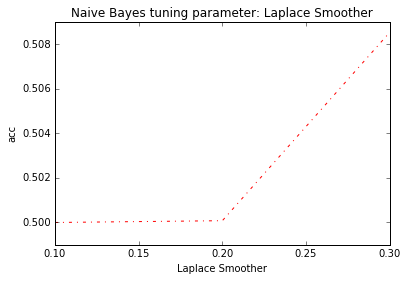

In [87]:
from sklearn.naive_bayes import MultinomialNB
###use only word-Ngram-features
param_l=[]
error_l=[]
for param in [[0.1,0.9],[0.2,0.8],[0.3,0.7]]:
    scores = []
    start_time = time.time()
    #submission = pd.DataFrame.from_dict({'id': test['id']})
    for class_name in ['sentiment']:
        train_target = train_df[class_name]
        classifier = MultinomialNB(0.1,class_prior=param)

        cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='accuracy'))
        scores.append(cv_score)
        ##print('CV score for class {} is {}'.format(class_name, cv_score))
        #train_scores, valid_scores = validation_curve(Ridge(), train_features, train_target, "alpha",np.logspace(-7, 3, 3))


        classifier.fit(train_word_features, train_target)

    print("for prior_class",param[0])
    print('Using naive bayes...Total CV acc score is {}'.format(np.mean(scores)))
    elapsed_time = time.time() - start_time
    print("elapsed_time is:",elapsed_time)
    param_l.append(param[0])
    error_l.append(np.mean(scores))
    print("-------------------------")
plt.title("Naive Bayes tuning parameter: Laplace Smoother")
plt.ylabel("acc")
plt.xlabel("Laplace Smoother")
plt.plot(param_l, error_l, color="red", linewidth=1.0, linestyle="-.")
